In [1]:
ALPHA = 0.01
NUM_ROUNDS = 25
CLIENTS_PER_ROUND = 3
LOCAL_EPOCHS = 5

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pickle
import matplotlib.pyplot as plt

# ============================
# 1. CARREGAR DADOS (simplificado)
# ============================
print("="*60)
print("TREINAMENTO FEDERADO - VERSÃO SIMPLIFICADA E CORRETA")
print("="*60)

with open(f'dataset/federated_datasets_dirichlet_{ALPHA}.pkl', 'rb') as f:
    data = pickle.load(f)

fed_datasets = data[f'fed_datasets_alpha_{ALPHA}']
test_dataset = data['data_global_test']
class_names = test_dataset['class_names']

# Selecionar 5 clientes
client_keys = list(fed_datasets.keys())[:5]
clients_data = {key: fed_datasets[key] for key in client_keys}

print(f"\nClientes selecionados: {len(clients_data)}")

# ============================
# 2. FUNÇÃO PARA CRIAR MODELO (UMA SÓ VEZ)
# ============================
def create_simple_cnn(input_shape, num_classes):
    """Cria modelo UMA vez no início"""
    # model = keras.Sequential([
    #     layers.Conv1D(32, 15, activation='relu', padding='same', input_shape=input_shape),
    #     layers.MaxPooling1D(4),
    #     layers.Dropout(0.3),
        
    #     layers.Conv1D(64, 7, activation='relu', padding='same'),
    #     layers.MaxPooling1D(4),
    #     layers.Dropout(0.4),
        
    #     layers.GlobalAveragePooling1D(),
    #     layers.Dense(32, activation='relu'),
    #     layers.Dropout(0.5),
    #     layers.Dense(num_classes, activation='softmax')
    # ])

#    return model  

    model = models.Sequential([

        # Bloco 1 – eventos rápidos
        layers.Conv1D(32, 3, activation='relu', padding='same',
                      input_shape=input_shape),
        layers.GroupNormalization(groups=8),
        layers.MaxPooling1D(2),

        # Bloco 2 – padrões locais
        layers.Conv1D(64, 5, activation='relu', padding='same'),
        layers.GroupNormalization(groups=8),
        layers.MaxPooling1D(2),

        # Bloco 3 – contexto global
        layers.Conv1D(128, 7, activation='relu', padding='same'),
        layers.GroupNormalization(groups=8),
        layers.MaxPooling1D(2),

        layers.GlobalAveragePooling1D(),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

    return model
    
# ============================
# 3. PRÉ-PROCESSAMENTO SIMPLIFICADO
# ============================
def simple_preprocess(X, y, num_classes):
    if len(X.shape) == 2:
        X = X.reshape(X.shape[0], X.shape[1], 1)
    
    # Normalização simples
    X = X.astype('float32')
    X = (X - np.mean(X)) / (np.std(X) + 1e-8)
    
    y = keras.utils.to_categorical(y, num_classes)
    return X, y

# Pré-processar teste
X_test_raw = test_dataset['X']
y_test_raw = test_dataset['y']
X_test, y_test = simple_preprocess(X_test_raw, y_test_raw, len(class_names))
input_shape = X_test.shape[1:]
num_classes = len(class_names)

# Pré-processar clientes
clients_processed = {}
for client_name, data_dict in clients_data.items():
    X, y = simple_preprocess(data_dict['X'], data_dict['y'], num_classes)
    clients_processed[client_name] = {'X': X, 'y': y, 'n_samples': len(X)}

print(f"\nInput shape: {input_shape}")
print(f"Número de classes: {num_classes}")

# ============================
# 4. TREINAMENTO FEDERADO CORRETO
# ============================
print("\n" + "="*60)
print("INICIANDO TREINAMENTO FEDERADO")
print("="*60)

# 1. Criar modelo global UMA VEZ
print("Criando modelo global inicial...")
global_model = create_simple_cnn(input_shape, num_classes)

# 2. Criar modelos locais (cópias vazias que serão preenchidas)
print("Criando modelos locais (cópias)...")
local_models = {}
for client_name in clients_processed.keys():
    # Cria estrutura vazia
    local_models[client_name] = create_simple_cnn(input_shape, num_classes)

# Histórico
history = {'test_acc': [], 'round': []}

# 4. LOOP PRINCIPAL CORRETO
for round_num in range(NUM_ROUNDS):
    print(f"\n{'='*40}")
    print(f"RODADA {round_num + 1}/{NUM_ROUNDS}")
    print('='*40)
    
    print(f"Passo 1: Enviando modelo global ATUAL para clientes...")
    
    # ATUALIZAR TODOS os modelos locais com pesos globais ATUAIS
    global_weights = global_model.get_weights()
    for client_name in local_models.keys():
        local_models[client_name].set_weights(global_weights)
    
    print(f"✓ Todos os {len(local_models)} modelos locais atualizados com pesos globais")
    
    # Selecionar clientes para esta rodada
    selected_clients = np.random.choice(
        list(clients_processed.keys()),
        size=CLIENTS_PER_ROUND,
        replace=False
    )
    
    print(f"Passo 2: Treinando {len(selected_clients)} clientes selecionados...")
    
    client_weights_list = []
    client_samples_list = []
    
    for client_name in selected_clients:
        # Modelo local JÁ TEM pesos atualizados do global
        local_model = local_models[client_name]
        client_data = clients_processed[client_name]
        
        X_train = client_data['X']
        y_train = client_data['y']
        n_samples = client_data['n_samples']
        
        # Treinar localmente (poucas épocas)
        local_model.fit(
            X_train, y_train,
            epochs=LOCAL_EPOCHS,
            batch_size=32,
            verbose=0
        )
        
        # Coletar pesos atualizados
        client_weights = local_model.get_weights()
        client_weights_list.append(client_weights)
        client_samples_list.append(n_samples)
        
        # Avaliar localmente (opcional)
        local_loss, local_acc = local_model.evaluate(X_train, y_train, verbose=0)
        print(f"  {client_name}: {n_samples} amostras, acc={local_acc:.3f}")
    
    print(f"Passo 3: Agregando pesos (FedAvg)...")
    
    # FedAvg simples
    total_samples = sum(client_samples_list)
    avg_weights = []
    
    # Inicializar com zeros
    for w in client_weights_list[0]:
        avg_weights.append(np.zeros_like(w))
    
    # Média ponderada
    for client_idx in range(len(client_weights_list)):
        weight = client_samples_list[client_idx] / total_samples
        client_weights = client_weights_list[client_idx]
        
        for layer_idx in range(len(avg_weights)):
            avg_weights[layer_idx] += client_weights[layer_idx] * weight
    
    print(f"Passo 4: Atualizando modelo global...")
    
    # ATUALIZAR modelo global com nova média
    global_model.set_weights(avg_weights)
    
    print(f"Passo 5: Avaliando modelo global atualizado...")
    
    # Avaliar no teste
    test_loss, test_acc = global_model.evaluate(X_test, y_test, verbose=0)
    history['test_acc'].append(test_acc)
    history['round'].append(round_num + 1)
    
    print(f"✓ Modelo global atualizado!")
    print(f"✓ Acurácia no teste: {test_acc:.4f}")
    
    # Verificar progresso
    if round_num > 0:
        improvement = test_acc - history['test_acc'][-2]
        print(f"✓ Melhoria: {improvement:+.4f}")
    
    # Critério de parada
    if test_acc > 1.0:
        print(f"\n🎯 Meta alcançada! Acurácia: {test_acc:.4f}")
        break

# Salvar modelo global
global_model.save(f'resultados_federado/global_model_{ALPHA}.h5')
print("Modelo salvo em: dataset/cnn_model.h5")


# ============================
# 5. RESULTADO FINAL
# ============================
print("\n" + "="*60)
print("RESULTADO FINAL")
print("="*60)

print(f"\nRodadas executadas: {len(history['round'])}")
print(f"Acurácia inicial: {history['test_acc'][0]:.4f}")
print(f"Acurácia final: {history['test_acc'][-1]:.4f}")

TREINAMENTO FEDERADO - VERSÃO SIMPLIFICADA E CORRETA

Clientes selecionados: 5

Input shape: (1536, 1)
Número de classes: 16

INICIANDO TREINAMENTO FEDERADO
Criando modelo global inicial...
Criando modelos locais (cópias)...


c:\Users\marce\Desktop\Master Thesis Code\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



RODADA 1/25
Passo 1: Enviando modelo global ATUAL para clientes...
✓ Todos os 5 modelos locais atualizados com pesos globais
Passo 2: Treinando 3 clientes selecionados...
  data_fed_3: 5313 amostras, acc=1.000
  data_fed_2: 7649 amostras, acc=0.988
  data_fed_1: 9091 amostras, acc=0.987
Passo 3: Agregando pesos (FedAvg)...
Passo 4: Atualizando modelo global...
Passo 5: Avaliando modelo global atualizado...
✓ Modelo global atualizado!
✓ Acurácia no teste: 0.1039

RODADA 2/25
Passo 1: Enviando modelo global ATUAL para clientes...
✓ Todos os 5 modelos locais atualizados com pesos globais
Passo 2: Treinando 3 clientes selecionados...
  data_fed_5: 7605 amostras, acc=0.917
  data_fed_1: 9091 amostras, acc=0.936
  data_fed_4: 11142 amostras, acc=0.804
Passo 3: Agregando pesos (FedAvg)...
Passo 4: Atualizando modelo global...
Passo 5: Avaliando modelo global atualizado...
✓ Modelo global atualizado!
✓ Acurácia no teste: 0.2500
✓ Melhoria: +0.1461

RODADA 3/25
Passo 1: Enviando modelo global 

✓ Modelo global atualizado!
✓ Acurácia no teste: 0.4043
✓ Melhoria: +0.0369
Modelo salvo em: dataset/cnn_model.h5

RESULTADO FINAL

Rodadas executadas: 25
Acurácia inicial: 0.1039
Acurácia final: 0.4043


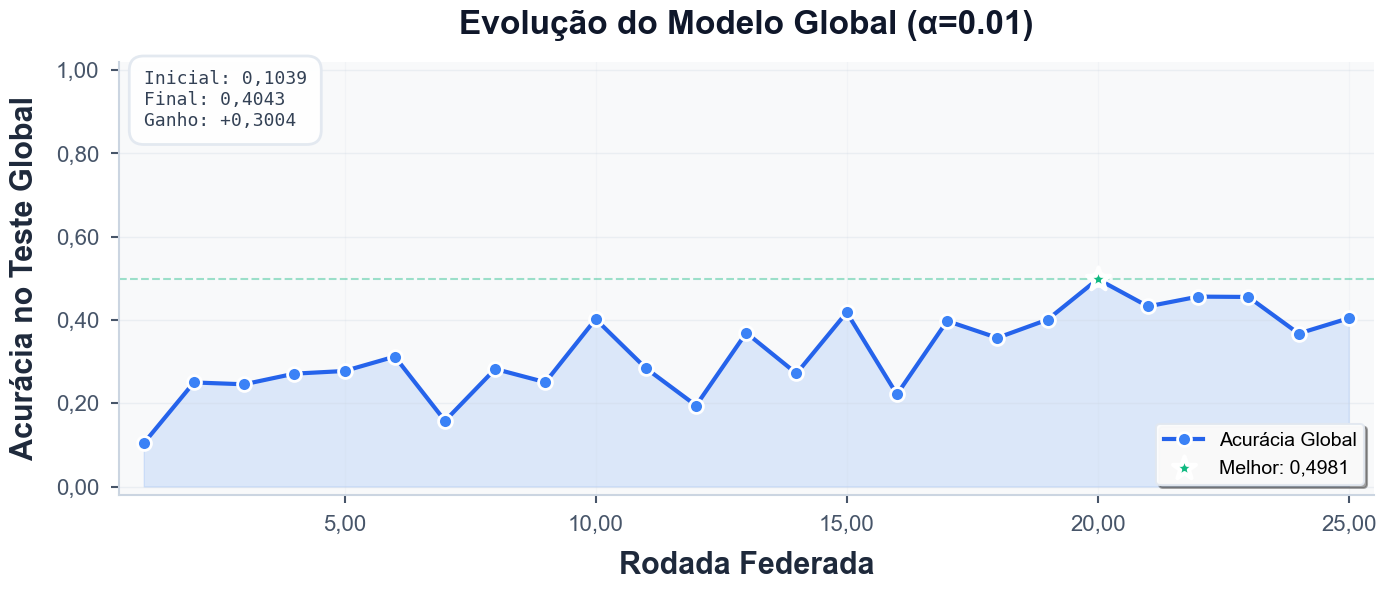


✅ Gráfico moderno criado com sucesso!


In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# --------------------------
# Função para trocar . por ,
# --------------------------
def virgula(x, pos):
    """Formata ticks usando vírgula como separador decimal."""
    s = f'{x:.2f}'
    return s.replace('.', ',')

formatter = FuncFormatter(virgula)

# --------------------------
# Configuração de Estilo Moderno
# --------------------------
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['figure.facecolor'] = 'white'

# Criar figura com fundo moderno
fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('#f8f9fa')

# --------------------------
# Plotar linha principal com gradiente
# --------------------------
# Linha principal mais grossa
line = ax.plot(history['round'], history['test_acc'], 
               color='#2563eb', linewidth=3, marker='o', 
               markersize=10, markerfacecolor='#3b82f6',
               markeredgecolor='white', markeredgewidth=2,
               label='Acurácia Global', zorder=3)

# Adicionar área sombreada abaixo da curva
ax.fill_between(history['round'], 0, history['test_acc'], 
                alpha=0.15, color='#3b82f6', zorder=1)

# Destacar melhor resultado
best_idx = np.argmax(history['test_acc'])
best_round = history['round'][best_idx]
best_acc = history['test_acc'][best_idx]

ax.scatter(best_round, best_acc, s=300, color='#10b981', 
          edgecolor='white', linewidth=3, zorder=4, 
          marker='*', label=f'Melhor: {best_acc:.4f}'.replace('.', ','))

# Adicionar linha tracejada no melhor valor
ax.axhline(y=best_acc, color='#10b981', linestyle='--', 
          linewidth=1.5, alpha=0.4, zorder=2)

# --------------------------
# Grid moderno
# --------------------------
ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=1, color='#cbd5e1')
ax.grid(True, axis='x', alpha=0.15, linestyle='-', linewidth=0.8, color='#cbd5e1')

# --------------------------
# Eixos e limites
# --------------------------
ax.set_ylim(-0.02, 1.02)
ax.set_xlim(history['round'][0] - 0.5, history['round'][-1] + 0.5)

# --------------------------
# Labels com estilo
# --------------------------
ax.set_xlabel('Rodada Federada', fontsize=22, fontweight='600', 
              color='#1e293b', labelpad=12)
ax.set_ylabel('Acurácia no Teste Global', fontsize=22, fontweight='600', 
              color='#1e293b', labelpad=12)
ax.set_title(f'Evolução do Modelo Global (α={ALPHA})', 
            fontsize=24, fontweight='bold', color='#0f172a', pad=20)

# --------------------------
# Ticks personalizados
# --------------------------
ax.tick_params(axis='both', labelsize=16, colors='#475569', 
              length=6, width=1.5, pad=8)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)

# Remover bordas superiores e direitas (estilo minimalista)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cbd5e1')
ax.spines['bottom'].set_color('#cbd5e1')
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# --------------------------
# Legenda moderna
# --------------------------
legend = ax.legend(loc='lower right', fontsize=14, frameon=True, 
                  fancybox=True, shadow=True, framealpha=0.95,
                  edgecolor='#e2e8f0', facecolor='white')
legend.get_frame().set_linewidth(1.5)

# --------------------------
# Anotações adicionais
# --------------------------
# Mostrar acurácia inicial e final
initial_acc = history['test_acc'][0]
final_acc = history['test_acc'][-1]
improvement = final_acc - initial_acc

# Texto no canto superior esquerdo
textstr = f'Inicial: {initial_acc:.4f}\nFinal: {final_acc:.4f}\nGanho: {improvement:+.4f}'
textstr = textstr.replace('.', ',')

props = dict(boxstyle='round,pad=0.8', facecolor='white', 
            edgecolor='#e2e8f0', linewidth=2, alpha=0.95)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=13,
        verticalalignment='top', bbox=props, color='#334155',
        fontweight='500', family='monospace')

# --------------------------
# Ajustes finais
# --------------------------
plt.tight_layout()

# Salvar com alta qualidade
plt.savefig(f'resultados_federado/evolucao_modelo_global_{ALPHA}.png', 
           dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')

plt.show()

print("\n✅ Gráfico moderno criado com sucesso!")

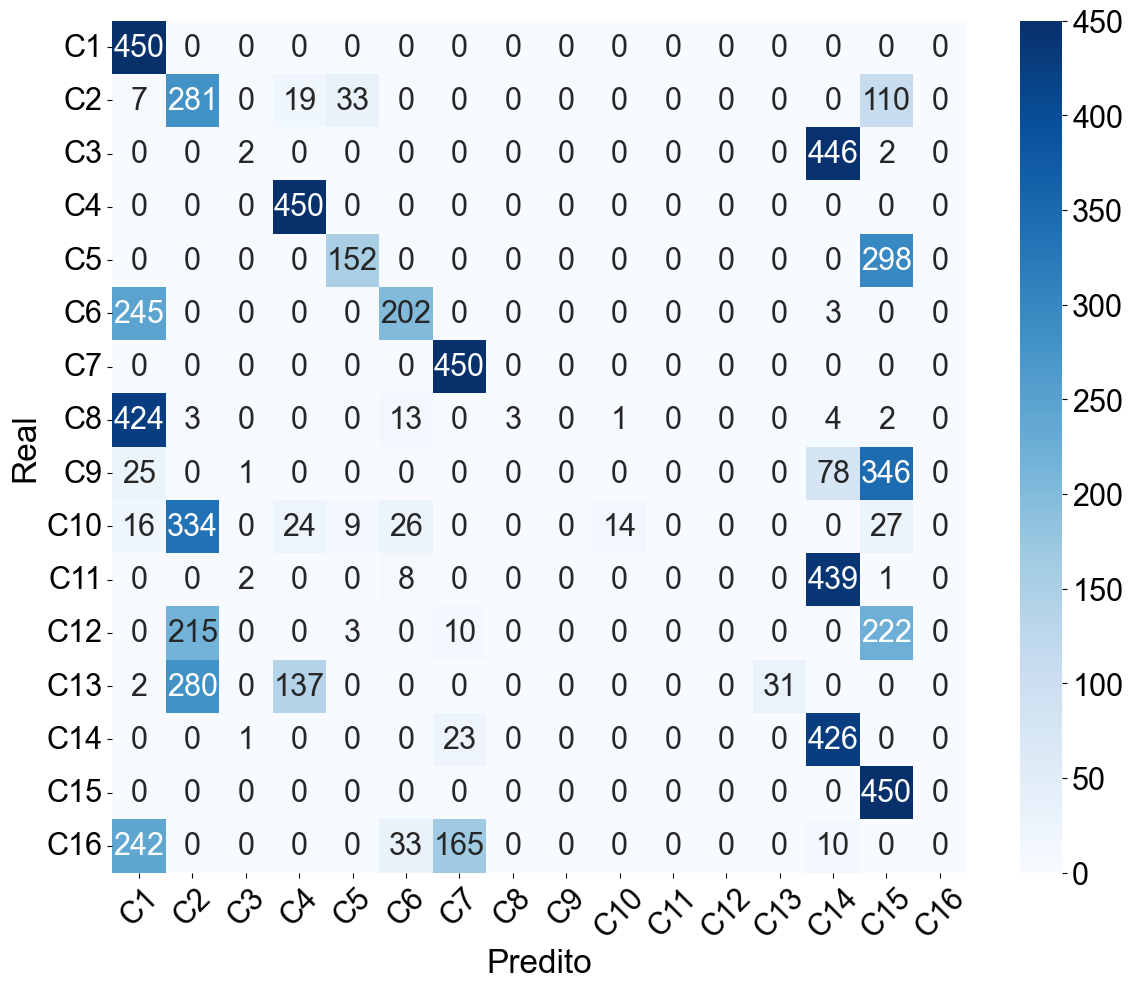

In [4]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Se y_test estiver one-hot encoded, converta para classes
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_classes = np.argmax(y_test, axis=1)
else:
    y_test_classes = y_test

# Predições
y_pred = global_model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Matriz de confusão
cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(12, 10))

ax = sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=[f'C{i+1}' for i in range(len(class_names))],
    yticklabels=[f'C{i+1}' for i in range(len(class_names))],
    annot_kws={"size": 22}  # valores internos
)

# Ticks dos eixos X e Y
plt.xticks(fontsize=22, rotation=45)
plt.yticks(fontsize=22, rotation=0)

# Aumentar o eixo auxiliar (colorbar)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)

plt.xlabel('Predito', fontsize=24)
plt.ylabel('Real', fontsize=24)

plt.tight_layout()
plt.savefig(f'resultados_federado/federado_matriz_confusao_{ALPHA}.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# Relatório de classificação
report_text = "\n" + "="*60 + "\n"
report_text += "RELATÓRIO DE CLASSIFICAÇÃO\n"
report_text += "="*60 + "\n"
report_text += classification_report(y_test_classes, y_pred_classes, 
                                     target_names=[f'C{i+1}' for i in range(len(class_names))])

# Imprimir no console
print(report_text)

# Salvar em arquivo
with open(f'resultados_federado/relatorio_classificacao_{ALPHA}.txt', 'w', encoding='utf-8') as f:
    f.write(report_text)

print("\nRelatório salvo em 'relatorio_classificacao.txt'")


RELATÓRIO DE CLASSIFICAÇÃO
              precision    recall  f1-score   support

          C1       0.32      1.00      0.48       450
          C2       0.25      0.62      0.36       450
          C3       0.33      0.00      0.01       450
          C4       0.71      1.00      0.83       450
          C5       0.77      0.34      0.47       450
          C6       0.72      0.45      0.55       450
          C7       0.69      1.00      0.82       450
          C8       1.00      0.01      0.01       450
          C9       0.00      0.00      0.00       450
         C10       0.93      0.03      0.06       450
         C11       0.00      0.00      0.00       450
         C12       0.00      0.00      0.00       450
         C13       1.00      0.07      0.13       450
         C14       0.30      0.95      0.46       450
         C15       0.31      1.00      0.47       450
         C16       0.00      0.00      0.00       450

    accuracy                           0.40      720

c:\Users\marce\Desktop\Master Thesis Code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marce\Desktop\Master Thesis Code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marce\Desktop\Master Thesis Code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me